In [185]:
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

names = range(100)
dates = pd.date_range(start='2022-01-01', end='2022-12-31')

rng = np.random.default_rng()
activity = (rng.random((len(dates), len(names))) > 0.5).astype(int)
activity = (np.random.randn(len(dates), len(names)) > 0.5).astype(int)
activity = (np.random.normal(-0.1, 0.5, (len(dates), len(names))) > 0.5).astype(int)
df = pd.DataFrame(activity, index=dates, columns=[f'user-{n}' for n in names])

sum_check = df.sum()
assert len(sum_check[sum_check == 0]) == 0

df.head()

,user-0,user-1,user-2,user-3,user-4,user-5,user-6,user-7,user-8,user-9,...,user-90,user-91,user-92,user-93,user-94,user-95,user-96,user-97,user-98,user-99
2022-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2022-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2022-01-03,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2022-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-05,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


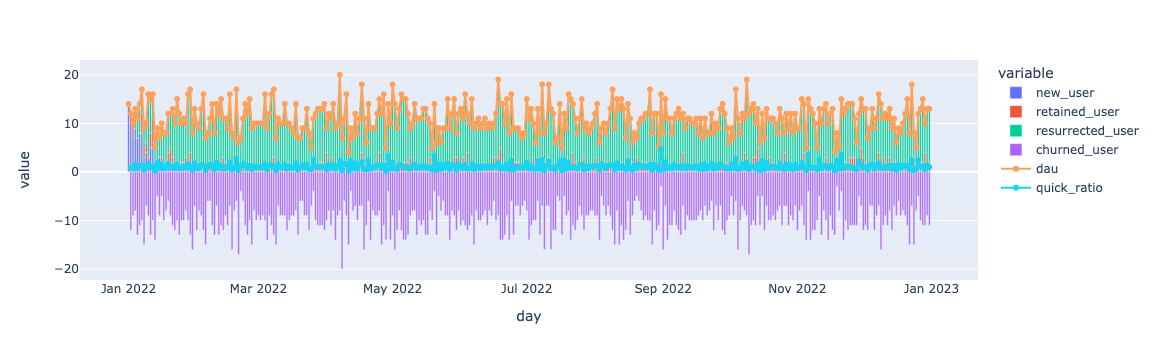

In [192]:
def get_dau(input_df):
    return df.sum(axis=1)

def common_new_user(df):
    original_df = df
    _, new_user_with_full_dates = original_df.align(
        pd.DataFrame(df.T.idxmax(axis=1)).assign(count=1).pivot(columns=0, values='count').T,
        join='outer'
    )
    return new_user_with_full_dates.fillna(0)

def get_new_user(df):
    return common_new_user(df).sum(axis=1)

def get_new_user_mask(df):
    return common_new_user(df).cumsum(axis=0).astype(bool)

def get_resurrected_user(df):
    shifted_df = (df - df.shift(1) == 1)
    not_new_user_df = ~common_new_user(df).astype(bool)
    left, right = shifted_df.align(not_new_user_df, axis=0, join='outer')
    return (left & right.fillna(True)).sum(axis=1).fillna(0)

def get_retained_user(df):
    return ((df - df.shift(1) == 0) & df.astype(bool)).sum(axis=1)

def get_churned_user(df):
    return (df - df.shift(1) == -1).sum(axis=1)

def get_continuous_churned_user(df):
    return ((df - df.shift(1) == 0) & ~df.astype(bool)).sum(axis=1)

new = df.assign(
    dau=get_dau(df),
    new_user=get_new_user(df),
    retained_user=get_retained_user(df),
    churned_user=get_churned_user(df),
    continuous_churned_user=get_continuous_churned_user(df),
    resurrected_user=get_resurrected_user(df),
)
new['dau_cal'] = new.new_user.fillna(0) + new.retained_user + new.resurrected_user
new['total'] = new.new_user.fillna(0) + new.retained_user + new.resurrected_user + new.churned_user + new.continuous_churned_user
new['check'] = new['dau'] == new['dau_cal']
new.index.name = 'day'

# display(new.head())
# # Check
# test1 = df.loc[['2022-01-01']].T
# display(test1[test1['2022-01-01'] == 1].sort_index())
# test2 = pd.DataFrame(df.T.idxmax(axis=1)).assign(count=1).pivot(columns=0, values='count').T.loc[['2022-01-01']].T.fillna(0)
# display(test2[test2['2022-01-01'] == 1].sort_index())


## Plot
new['quick_ratio'] = (new.new_user + new.resurrected_user) / new.churned_user
new['churned_user'] = -new['churned_user']
new['continuous_churned_user'] = -new['continuous_churned_user']

# fig_dau = go.Scatter(
#     x=new.index,
#     y=new['dau'],
#     text=new['dau'],
#     textposition='top center',
#     mode='lines+markers+text',
#     name='dau'
# )

# Non-WebGL mode
# fig_dau = new['dau'].plot(markers=True).data[0]
# fig_quick_ratio = new['quick_ratio'].plot(markers=True).data[0]

# WebGL mode
fig_dau = go.Scattergl(
    x=new.index,
    y=new['dau'],
    name='dau',
    mode='lines+markers',
)

fig_quick_ratio = go.Scattergl(
    x=new.index,
    y=new['quick_ratio'],
    name='quick_ratio',
    mode='lines+markers',
)

fig = new[['new_user', 'retained_user', 'resurrected_user', 'churned_user']].plot.bar()
fig.add_trace(fig_dau)
fig.add_trace(fig_quick_ratio)
fig